In [1]:
#Imports
import pandas as pd
import csv
from api_keys import census_api
import json
import requests
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [2]:
#Input
traffic_data = "./Resources/US_Accidents_March23.csv"

In [3]:
traffic_df=pd.read_csv(traffic_data)
traffic_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
#Creating DataFrame w/ reduced columns
reduced_traffic_df = traffic_df[["Start_Time","End_Time","Severity","City","State","Weather_Condition",
                                 "Temperature(F)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)",\
                                 "Sunrise_Sunset","Description","Bump","Crossing", "Give_Way","Junction",\
                                 "No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming",\
                                 "Traffic_Signal","Turning_Loop","Description"
                                ]]
reduced_traffic_df.shape

(7728394, 25)

In [5]:
#Using function to parse date and convert to strint
def parse_time(raw):
    date = dt.datetime.fromisoformat(raw).date()
    string = date.isoformat()
    return string

In [6]:
reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/4217142928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/4217142928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)


In [7]:
#using function to extract Year from date
def year(raw):
    year_string = raw[:4]
    year_integer = int(year_string)
    return year_integer  

In [8]:
reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/3843608378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/3843608378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)


In [9]:
#dropping NA from df
drop_traffic_df = reduced_traffic_df.dropna(how='any')
drop_traffic_df.shape

(5382749, 29)

In [10]:
#Using function to format the drop traffic dataframe
drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
drop_traffic_df.loc[:, "Start_Year"] = drop_traffic_df['Start_Date'].map(year)
drop_traffic_df.loc[:, "End_Year"] = drop_traffic_df['End_Date'].map(year)
drop_traffic_df.shape

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/3689601372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/3689601372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/3689601372.py:4: SettingW

(5382749, 29)

In [11]:
#reorganizing columns
organized_traffic_df = reduced_traffic_df[["Start_Year","Start_Date","End_Year","End_Date","Start_Time","End_Time",\
                                        "Severity","City","State","Weather_Condition","Temperature(F)","Visibility(mi)",\
                                        "Wind_Speed(mph)","Precipitation(in)","Sunrise_Sunset","Description","Bump",\
                                        "Crossing", "Give_Way","Junction","No_Exit","Railway","Roundabout","Station",\
                                        "Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]]
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,2016-02-08,2016,2016-02-08,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
1,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
2,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,...,False,False,False,False,False,False,False,False,True,False
3,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
4,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,True,False


In [59]:
organized_traffic_gp = organized_traffic_df.groupby(["Start_Year"]).State.count()
organized_traffic_gp

Start_Year
2016     410821
2017     718093
2018     893426
2019     954303
2020    1178913
2021    1563753
2022    1762452
2023     246633
Name: State, dtype: int64

# Census API

In [19]:
#Calling Census API
base_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*"
api_url = f"{base_url}&key={census_api}"
json_url = requests.get(api_url).json()
print(api_url)

https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*&key=9adc74e4cfc4d4a300ce521d201d867bcab7e31a


In [20]:
#Creating DataFrame from API
api_df = pd.DataFrame(json_url)
api_df

,0,1,2,3
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [21]:
#Renaming column headers
api_df.columns=["City","Population","State #","Place #"]

In [22]:
#Drop original column
drop = api_df.drop([0,0])

In [23]:
#Splitting City and State
split_cl = drop["City"].str.split(',',expand=True)

In [24]:
#Renaming Column Header
split_cl.columns=["City_1","State",""]
split_cl

,City_1,State,
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None
31907,Yaurel comunidad,Puerto Rico,None


In [25]:
df =pd.concat([drop,split_cl],axis=1)
drop_df = df.drop([""],axis=1)
drop_df.head()

,City,Population,State #,Place #,City_1,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [26]:
#Creating function to trim spaces
def trim(raw):
    trim = raw.strip()
    return trim

In [27]:
#Trimming space on State Column
drop_df["State"]= drop_df["State"].map(trim)

In [28]:
#Renaming columns
census_rename_df = drop_df.rename(columns={"City":"City_State","City_1":"City"})
census_rename_df.head()

,City_State,Population,State #,Place #,City,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [29]:
#Reordering columns
organized_census_df = census_rename_df[["City","State","Population","State #","Place #","City_State" 
]]
organized_census_df.head()

,City,State,Population,State #,Place #,City_State
1,Abanda CDP,Alabama,231,01,00100,"Abanda CDP, Alabama"
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
4,Addison town,Alabama,697,01,00484,"Addison town, Alabama"
5,Akron town,Alabama,385,01,00676,"Akron town, Alabama"


In [30]:
#Pulling City and excluding Puerto Rico
census_clean_df = organized_census_df[(organized_census_df["City"].str.contains("city")) \
                                      & (organized_census_df["State"] != "Puerto Rico")]
census_clean_df

,City,State,Population,State #,Place #,City_State
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama"
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama"
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama"
...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming"
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming"
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming"
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming"


In [31]:
#Converting population to integer
census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/243609777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/243609777.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)


In [32]:
#Function to strip "city" from City
def strip(raw):
    city = raw.strip("city")
    trim = city.strip()
    return trim

In [33]:
census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/3544217579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip)


In [34]:
city_rename = census_clean_df.rename(columns={"City": "City1","City2": "City"})
city_rename

,City1,State,Population,State #,Place #,City_State,City
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City
...,...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming",Riverton
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming",Rock Springs
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming",Sheridan
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming",Torrington


In [35]:
#Importing City and State abbrev.
crosswalk_path = "Resources/crosswalk.csv"
state_abv = pd.read_csv(crosswalk_path)

In [36]:
#Merging abbriviation data to census
crosswalk_state = pd.merge(city_rename,state_abv,on="State")

In [37]:
rename_cross = crosswalk_state.rename(columns={"State":"State_old","Abbreviation":"State"})
rename_cross.head()

,City1,State_old,Population,State #,Place #,City_State,City,State
0,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville,AL
1,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville,AL
2,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster,AL
3,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville,AL
4,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City,AL


In [38]:
sorted_og_traffic = organized_traffic_df.sort_values(by=["State","City"],ascending=True)
sorted_og_traffic.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
523666,2022,2022-08-27,2022,2022-08-27,2022-08-27 14:47:41,2022-08-27 15:17:20,2,Abbeville,AL,Thunder in the Vicinity,...,True,False,False,False,False,False,False,False,False,False
530035,2022,2022-08-20,2022,2022-08-20,2022-08-20 16:32:02,2022-08-20 17:01:44,2,Abbeville,AL,Fair,...,False,False,False,False,False,False,False,False,False,False
536021,2022,2022-08-12,2022,2022-08-12,2022-08-12 20:30:17,2022-08-12 21:19:12,1,Abbeville,AL,Fair,...,True,False,False,False,False,False,False,False,False,False
548951,2022,2022-07-29,2022,2022-07-29,2022-07-29 06:38:49,2022-07-29 07:38:24,2,Abbeville,AL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
557220,2022,2022-07-20,2022,2022-07-20,2022-07-20 12:57:22,2022-07-20 13:40:00,2,Abbeville,AL,Partly Cloudy,...,False,False,False,False,False,False,False,False,False,False


In [39]:
state_accidents = sorted_og_traffic.groupby(["Start_Year","State","City"]).count()

In [40]:
#Resetting index on state_accidents
clean_reset_df = state_accidents.reset_index()
clean_reset_df

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2016,AL,Athens,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2016,AL,Atmore,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,2016,AL,Attalla,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,2016,AL,Auburn,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97722,2023,WY,Rock Springs,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
97723,2023,WY,Sinclair,36,36,36,36,36,36,33,...,36,36,36,36,36,36,36,36,36,36
97724,2023,WY,Wamsutter,77,77,77,77,77,77,29,...,77,77,77,77,77,77,77,77,77,77
97725,2023,WY,Wheatland,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [41]:
#Merging Census and City Traffic data
state_city_accident_census = pd.merge(clean_reset_df,rename_cross,on=["State","City"],how="inner")
state_city_accident_census

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,City1,State_old,Population,State #,Place #,City_State
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
1,2018,AL,Ashville,11,11,11,11,11,11,11,...,11,11,11,11,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
2,2019,AL,Ashville,8,8,8,8,8,8,8,...,8,8,8,8,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
3,2020,AL,Ashville,7,7,7,7,7,7,7,...,7,7,7,7,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
4,2021,AL,Ashville,18,18,18,18,18,18,15,...,18,18,18,18,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,2023,TX,Talco,1,1,1,1,1,1,1,...,1,1,1,1,Talco city,Texas,577,48,71732,"Talco city, Texas"
36920,2023,TX,Trenton,3,3,3,3,3,3,3,...,3,3,3,3,Trenton city,Texas,729,48,73592,"Trenton city, Texas"
36921,2023,WV,Follansbee,1,1,1,1,1,1,1,...,1,1,1,1,Follansbee city,West Virginia,2842,54,28204,"Follansbee city, West Virginia"
36922,2023,WV,McMechen,1,1,1,1,1,1,1,...,1,1,1,1,McMechen city,West Virginia,1667,54,50260,"McMechen city, West Virginia"


In [42]:
#Simplifying columns
city_accident_census = state_city_accident_census[["State","City","Start_Year","Population","Start_Date"]]
city_accident_census.head()

,State,City,Start_Year,Population,Start_Date
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18


In [43]:
#Merging census and traffic data
census_traffic_df = pd.merge(reduced_traffic_df,rename_cross,on=["State","City"],how="inner")
census_traffic_df.head()

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
0,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,36.9,10.0,NaN,0.02,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
1,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,35.1,9.0,4.6,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
2,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,36.0,6.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
3,2016-02-08 07:59:35,2016-02-08 08:29:35,2,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
4,2016-02-08 07:59:58,2016-02-08 08:29:58,3,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"


In [44]:
#Renaming colums
census_accidents_pop =city_accident_census.rename(columns={"Start_Date":"Accidents"})
census_accidents_pop

,State,City,Start_Year,Population,Accidents
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18
...,...,...,...,...,...
36919,TX,Talco,2023,577,1
36920,TX,Trenton,2023,729,3
36921,WV,Follansbee,2023,2842,1
36922,WV,McMechen,2023,1667,1


In [45]:
#Population per 100K
census_accidents_pop["pop_per_100K"] = census_accidents_pop["Population"]/100000
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K
0,AL,Ashville,2016,2096,1,0.02096
1,AL,Ashville,2018,2096,11,0.02096
2,AL,Ashville,2019,2096,8,0.02096
3,AL,Ashville,2020,2096,7,0.02096
4,AL,Ashville,2021,2096,18,0.02096
...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577
36920,TX,Trenton,2023,729,3,0.00729
36921,WV,Follansbee,2023,2842,1,0.02842
36922,WV,McMechen,2023,1667,1,0.01667


In [46]:
#Accidents per 100K population
census_accidents_pop["accidents_per_pop_100K"] = census_accidents_pop["Accidents"] / census_accidents_pop["pop_per_100K"]
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
0,AL,Ashville,2016,2096,1,0.02096,47.709924
1,AL,Ashville,2018,2096,11,0.02096,524.809160
2,AL,Ashville,2019,2096,8,0.02096,381.679389
3,AL,Ashville,2020,2096,7,0.02096,333.969466
4,AL,Ashville,2021,2096,18,0.02096,858.778626
...,...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577,173.310225
36920,TX,Trenton,2023,729,3,0.00729,411.522634
36921,WV,Follansbee,2023,2842,1,0.02842,35.186488
36922,WV,McMechen,2023,1667,1,0.01667,59.988002


In [47]:
#Filtering on population >100K
major_cities = census_accidents_pop[census_accidents_pop["Population"]>=100000]

In [48]:
#Outputting major cities to csv
major_cities.to_csv("./outputs/major_cities.csv", index=False, header=True)

In [49]:
major_cities.sort_values(by=["accidents_per_pop_100K"],ascending=False)

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
5112,FL,Miami,2022,440807,64505,4.40807,14633.388308
5111,FL,Miami,2021,440807,58816,4.40807,13342.800818
5317,FL,Orlando,2022,302968,36402,3.02968,12015.130311
5316,FL,Orlando,2021,302968,33014,3.02968,10896.860394
11119,LA,Baton Rouge,2021,225539,14552,2.25539,6452.099193
...,...,...,...,...,...,...,...
20377,TX,Amarillo,2016,200371,1,2.00371,0.499074
264,AR,Little Rock,2016,201893,1,2.01893,0.495312
31833,FL,Port St. Lucie,2018,202177,1,2.02177,0.494616
30516,TX,Lubbock,2023,255537,1,2.55537,0.391333


In [50]:
accidents_per_pop = (major_cities["Accidents"]/major_cities["Population"])

In [51]:
accident_by_city = major_cities.groupby(["Start_Year","State","City"])

accident_df = accident_by_city.first()


In [52]:
accident_city_df = accident_df.reset_index()
accident_city_df.sort_values("Accidents",ascending=False)

,Start_Year,State,City,Population,Accidents,pop_per_100K,accidents_per_pop_100K
1871,2022,FL,Miami,440807,64505,4.40807,14633.388308
1576,2021,FL,Miami,440807,58816,4.40807,13342.800818
1874,2022,FL,Orlando,302968,36402,3.02968,12015.130311
1579,2021,FL,Orlando,302968,33014,3.02968,10896.860394
1802,2022,CA,Los Angeles,3902440,31072,39.02440,796.219801
...,...,...,...,...,...,...,...
2278,2023,TX,Corpus Christi,318168,1,3.18168,0.314299
1100,2019,SD,Sioux Falls,189258,1,1.89258,0.528379
2283,2023,TX,Frisco,193140,1,1.93140,0.517759
3,2016,AR,Little Rock,201893,1,2.01893,0.495312


# What were the changes in traffic accidents over time? 
Author: Velvet Robinson

In [60]:
organized_traffic_d = organized_traffic_gp.to_frame()

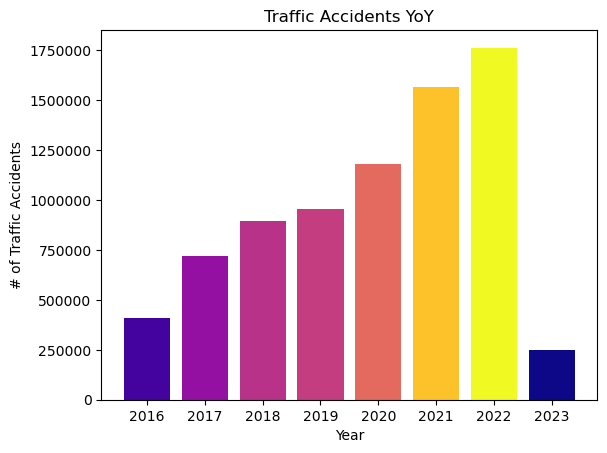

In [61]:
x_axis = organized_traffic_gp.index
y_axis = organized_traffic_gp.tolist()


my_cmap = plt.get_cmap("plasma")
rescale = lambda y_axis: (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))
plt.bar(x_axis,y_axis, color=my_cmap(rescale(y_axis)))
plt.ticklabel_format(style='plain')
# plt.bar(x_axis, y_axis,color=['b','b','b','b','b','b','r','b'],alpha=0.5, align="center")
plt.title("Traffic Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/AccidentsYoY.png")
plt.show()

In [62]:
comparison_df = organized_traffic_d[["State"]]
comparison_df
changes = []
pct_changes = []
previous_row = 0

for index, x in comparison_df.iterrows():
    accidents = x["State"]
    change = (accidents-previous_row)
    pct = change/previous_row*100
    changes.append(change)
    pct_changes.append(pct)
    previous_row = accidents

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/1050712285.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  pct = change/previous_row*100


In [63]:
comparison_df.loc[:,"Yearly Change"] = changes
comparison_df.loc[:,"Percent Change"] = pct_changes

In [64]:
comparison_df.loc[:,"Percent Change"]=comparison_df["Percent Change"].map("{:,.2f}%".format)
comparison_df

,State,Yearly Change,Percent Change
Start_Year,,,
2016,410821,410821,inf%
2017,718093,307272,74.79%
2018,893426,175333,24.42%
2019,954303,60877,6.81%
2020,1178913,224610,23.54%
2021,1563753,384840,32.64%
2022,1762452,198699,12.71%
2023,246633,-1515819,-86.01%


In [65]:
#Bar Graph, year over year of traffic accidents for all cities with pop over 100k in the US between 2016-2022
#Author: Velvet Robinson
major_cities_16_22_s = (census_traffic_df["Start_Year"] <2023) & (census_traffic_df["Population"] >=100000)
major_cities_16_22_df = census_traffic_df[major_cities_16_22_s]
major_cities_16_22_gp = major_cities_16_22_df.groupby("Start_Year").count()

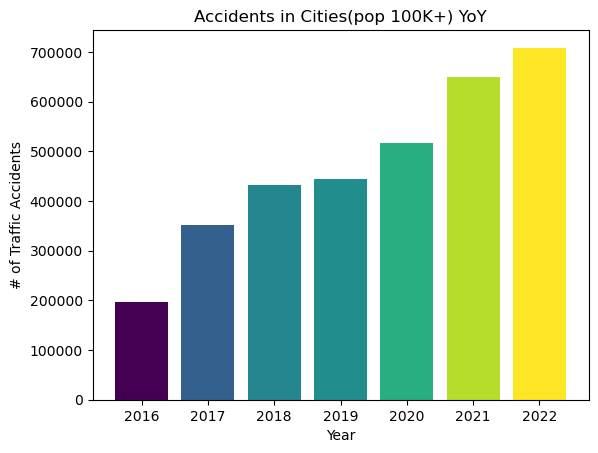

In [106]:
x_axis=major_cities_16_22_gp.index.tolist()
y_axis = major_cities_16_22_gp["State"].tolist()

my_cmap = plt.get_cmap("viridis")
rescale = lambda y_axis: (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))
plt.bar(x_axis,y_axis, color=my_cmap(rescale(y_axis)))

plt.ticklabel_format(style='plain')
plt.title("Accidents in Cities(pop 100K+) YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/MajorCitiesYoY.png")
plt.show()

In [67]:
#Creating DataFrame with total accidents 2016-2022
census_traffic_16_22_s = (census_traffic_df["Start_Year"] <2023)
census_traffic_16_22_df = census_traffic_df[census_traffic_16_22_s]
census_traffic_16_22_gp = census_traffic_16_22_df.groupby("Start_Year").count()

In [68]:
#Creating DataFrame with total accidents 2016-2022 and major cities(pop 100K+) 2016-2022
census_traffic_16_22_og = census_traffic_16_22_gp[["State"]]
census_traffic_16_22_rn = census_traffic_16_22_og.rename(columns={"State":"All_Accidents"})

major_cities_16_22_og = major_cities_16_22_gp[["State"]]
major_cities_16_22_rn = major_cities_16_22_og.rename(columns={"State":"Major_City_Accidents"})

census_traffic_16_22_rn["Major_City_Accidents"] = major_cities_16_22_rn["Major_City_Accidents"]

In [69]:
#Calculating percent of accidents occuring in cities w/ pop >100K
major_city_percent = (census_traffic_16_22_rn["Major_City_Accidents"]/
                      census_traffic_16_22_rn["All_Accidents"]) * 100
census_traffic_16_22_rn["Major_City_pct"] = major_city_percent.map("{:,.2f}%".format)
census_traffic_16_22_rn

,All_Accidents,Major_City_Accidents,Major_City_pct
Start_Year,,,
2016,304003,195686,64.37%
2017,526369,351006,66.68%
2018,658083,431321,65.54%
2019,714030,444736,62.29%
2020,851933,517558,60.75%
2021,1105547,650242,58.82%
2022,1210787,708272,58.50%


# Question: What cities had the greatest number of traffic accidents per population?
Author: Arpita Sharma

In [117]:
#First graph: Bar Graph, cities between 2016-2022 cities with pop over 100k had the highest average number of traffic accidents

#Restricting dataset to only include 2016-2022 data
major_cities_1622 = major_cities[major_cities["Start_Year"]!=2023]
major_cities_1622

#Getting the median number of traffic accidents per city
major_cities_1622_accidents_avg = major_cities_1622.groupby(["City","State"],as_index=False).mean()
major_cities_1622_accidents_avg

#Sorting to cities with the highest average number of accidents
major_cities_1622_accidents_avg_sorted = major_cities_1622_accidents_avg.sort_values(by=["accidents_per_pop_100K"], ascending=False)
major_cities_1622_accidents_avg_sorted

#Restricting data to top 10 cities
top_5_cities_1622 = major_cities_1622_accidents_avg_sorted[major_cities_1622_accidents_avg_sorted["accidents_per_pop_100K"]>=2600]
top_5_cities_1622

,City,State,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
159,Miami,FL,2019.0,440807.0,25933.428571,4.40807,5883.170769
191,Orlando,FL,2019.0,302968.0,15344.857143,3.02968,5064.844189
18,Baton Rouge,LA,2019.0,225539.0,10006.857143,2.25539,4436.863311
54,Columbia,SC,2019.0,137276.0,4887.285714,1.37276,3560.189483
215,Raleigh,NC,2019.0,462219.0,12018.428571,4.62219,2600.158923


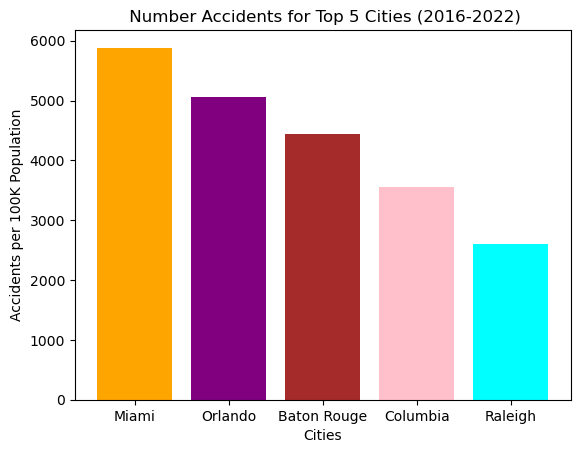

In [118]:
#Creating axis for plotting
x_axis = top_5_cities_1622["City"]
x_axis

y_axis = top_5_cities_1622["accidents_per_pop_100K"]
y_axis

# Define colors for each bar (use a list of colors)
colors = ['orange', 'purple', 'brown', 'pink', 'cyan', 'magenta']

#plotting bar charts
plt.bar(x_axis, y_axis,color=colors, align="center")

# Set x-axis labels and title
plt.xlabel('Cities')
plt.ylabel('Accidents per 100K Population')
plt.title(' Number Accidents for Top 5 Cities (2016-2022)')

#Save output png chart
plt.savefig("outputs/Accidents_Top5.png")
plt.show()

# Question: What cities had the greatest number of traffic accidents per population?
Author: Arpita Sharma

In [119]:
#Second graph:Clustered Bar Graph, top 3 cities between 2016-2022 that had the greatest number of traffic accidents per pop 

#Now looking at accidents by year for major cities
major_cities_1622_accidents_by_year = major_cities_1622.groupby(["Start_Year","City","State"],as_index=False).sum()
major_cities_1622_accidents_by_year

#Sorting to look at cities with the highest number of accidents per year
major_cities_1622_accidents_by_year_sorted = major_cities_1622_accidents_by_year.sort_values(by=["accidents_per_pop_100K"], ascending=False)
major_cities_1622_accidents_by_year_sorted

#selecting to the top three cities here
miami_data = major_cities_1622_accidents_by_year_sorted[major_cities_1622_accidents_by_year_sorted["City"]=="Miami"]
miami_data

orlando_data = major_cities_1622_accidents_by_year_sorted[major_cities_1622_accidents_by_year_sorted["City"]=="Orlando"]
orlando_data

baton_rouge_data = major_cities_1622_accidents_by_year_sorted[major_cities_1622_accidents_by_year_sorted["City"]=="Baton Rouge"]
baton_rouge_data

,Start_Year,City,State,Population,Accidents,pop_per_100K,accidents_per_pop_100K
1480,2021,Baton Rouge,LA,225539,14552,2.25539,6452.099193
1775,2022,Baton Rouge,LA,225539,13683,2.25539,6066.799977
598,2018,Baton Rouge,LA,225539,11983,2.25539,5313.050071
1186,2020,Baton Rouge,LA,225539,11578,2.25539,5133.480241
892,2019,Baton Rouge,LA,225539,11313,2.25539,5015.983932
304,2017,Baton Rouge,LA,225539,6658,2.25539,2952.039337
17,2016,Baton Rouge,LA,225539,281,2.25539,124.590426


In [120]:
#adding top three cities to same dataset
top_3_cities_1622_by_year = pd.concat([miami_data, orlando_data, baton_rouge_data])
top_3_cities_1622_by_year

,Start_Year,City,State,Population,Accidents,pop_per_100K,accidents_per_pop_100K
1913,2022,Miami,FL,440807,64505,4.40807,14633.388308
1618,2021,Miami,FL,440807,58816,4.40807,13342.800818
1322,2020,Miami,FL,440807,27089,4.40807,6145.319834
442,2017,Miami,FL,440807,9220,4.40807,2091.618327
734,2018,Miami,FL,440807,8637,4.40807,1959.360899
1029,2019,Miami,FL,440807,8129,4.40807,1844.117720
149,2016,Miami,FL,440807,5138,4.40807,1165.589476
1944,2022,Orlando,FL,302968,36402,3.02968,12015.130311
1649,2021,Orlando,FL,302968,33014,3.02968,10896.860394
1353,2020,Orlando,FL,302968,11840,3.02968,3908.003486


In [121]:
#restricting dataset to only display data for accidents_per_pop_100K
accidents_by_pop_top_cities = top_3_cities_1622_by_year[["Start_Year","State","City","accidents_per_pop_100K"]]
accidents_by_pop_top_cities

,Start_Year,State,City,accidents_per_pop_100K
1913,2022,FL,Miami,14633.388308
1618,2021,FL,Miami,13342.800818
1322,2020,FL,Miami,6145.319834
442,2017,FL,Miami,2091.618327
734,2018,FL,Miami,1959.360899
1029,2019,FL,Miami,1844.117720
149,2016,FL,Miami,1165.589476
1944,2022,FL,Orlando,12015.130311
1649,2021,FL,Orlando,10896.860394
1353,2020,FL,Orlando,3908.003486


In [122]:
#storting to display by smallest year to biggest year
accidents_by_pop_top_cities_sorted = accidents_by_pop_top_cities.sort_values(by=["Start_Year"], ascending=True)
accidents_by_pop_top_cities_sorted

,Start_Year,State,City,accidents_per_pop_100K
17,2016,LA,Baton Rouge,124.590426
181,2016,FL,Orlando,1951.361200
149,2016,FL,Miami,1165.589476
442,2017,FL,Miami,2091.618327
474,2017,FL,Orlando,2423.688310
304,2017,LA,Baton Rouge,2952.039337
598,2018,LA,Baton Rouge,5313.050071
765,2018,FL,Orlando,2426.658921
734,2018,FL,Miami,1959.360899
1029,2019,FL,Miami,1844.117720


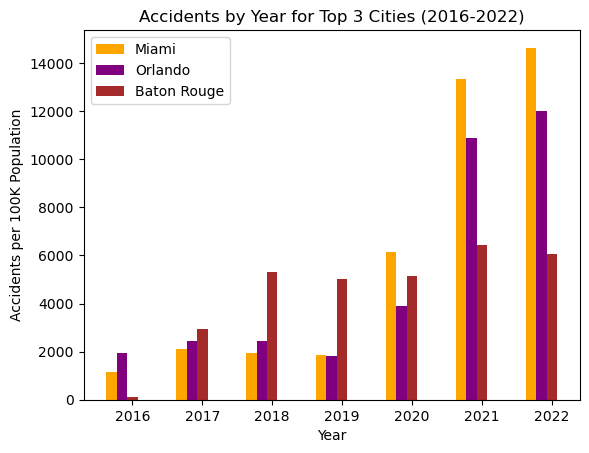

In [123]:
#creating variables for plotting
year= sorted(accidents_by_pop_top_cities_sorted["Start_Year"].unique())
miami_data_chart = accidents_by_pop_top_cities_sorted[accidents_by_pop_top_cities_sorted["City"] == "Miami"]["accidents_per_pop_100K"]
orlando_data_chart = accidents_by_pop_top_cities_sorted[accidents_by_pop_top_cities_sorted["City"] == "Orlando"]["accidents_per_pop_100K"]
baton_rouge_data_chart = accidents_by_pop_top_cities_sorted[accidents_by_pop_top_cities_sorted["City"] == "Baton Rouge"]["accidents_per_pop_100K"]

width = 0.15  # Adjust the width of the bars for clustering

# Create data for x-axis positions (shifted for clustered bars)
x = np.arange(len(year))

# Plot data in grouped manner of bar type
plt.bar(x - 2*width, miami_data_chart, width=width,color = "orange", label='Miami')
plt.bar(x - width, orlando_data_chart, width=width,color = "purple", label='Orlando')
plt.bar(x, baton_rouge_data_chart, width=width,color = "brown", label='Baton Rouge')


# Set x-axis labels and title
plt.xlabel('Year')
plt.ylabel('Accidents per 100K Population')
plt.xticks(x, year)
plt.title('Accidents by Year for Top 3 Cities (2016-2022)')

# Add a legend
plt.legend()

#save output png
plt.savefig("outputs/Accidents_Top3_By_Year.png")
plt.show()

# Show the chart
plt.show()

# Question: What cities experienced the greatest change in accidents in 2016-2022?

Author: Samin Nikkhoo

In [70]:
FIRST_YEAR=2016
LAST_YEAR=2022
MIN_MAJOR_CITY_SIZE=100000

In [71]:
# Filter cities with a population over 100,000
major_cities = major_cities[major_cities['Population'] >= MIN_MAJOR_CITY_SIZE]

# DataFrame for traffic accidents in 2016 and 2022
accidents_2016 = major_cities[major_cities['Start_Year'] == FIRST_YEAR][['City', 'accidents_per_pop_100K']]
accidents_2022 = major_cities[major_cities['Start_Year'] == LAST_YEAR][['City', 'accidents_per_pop_100K']]

# Merge the two DataFrames to calculate the change in accidents
accidents_change = pd.merge(accidents_2016, accidents_2022, on='City', suffixes=('_2016', '_2022'))
accidents_change

,City,accidents_per_pop_100K_2016,accidents_per_pop_100K_2022
0,Birmingham,13.845347,1573.424844
1,Mobile,3.734429,519.619088
2,Montgomery,6.466954,948.652386
3,Little Rock,0.495312,638.457004
4,Chandler,31.199645,450.743102
...,...,...,...
302,Tacoma,237.424769,581.598660
303,Vancouver,48.319183,303.189597
304,Green Bay,15.875536,91.517795
305,Madison,42.946426,332.646442


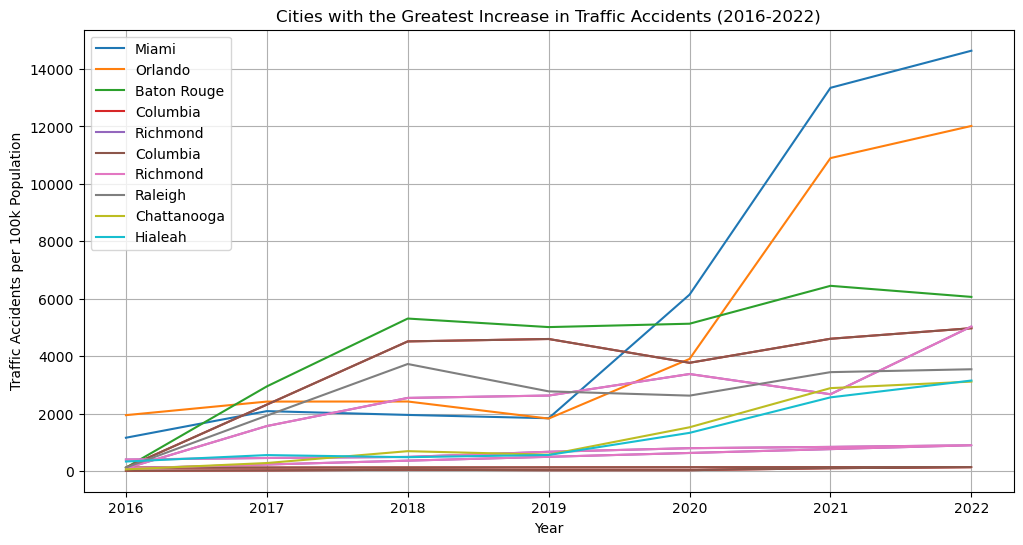

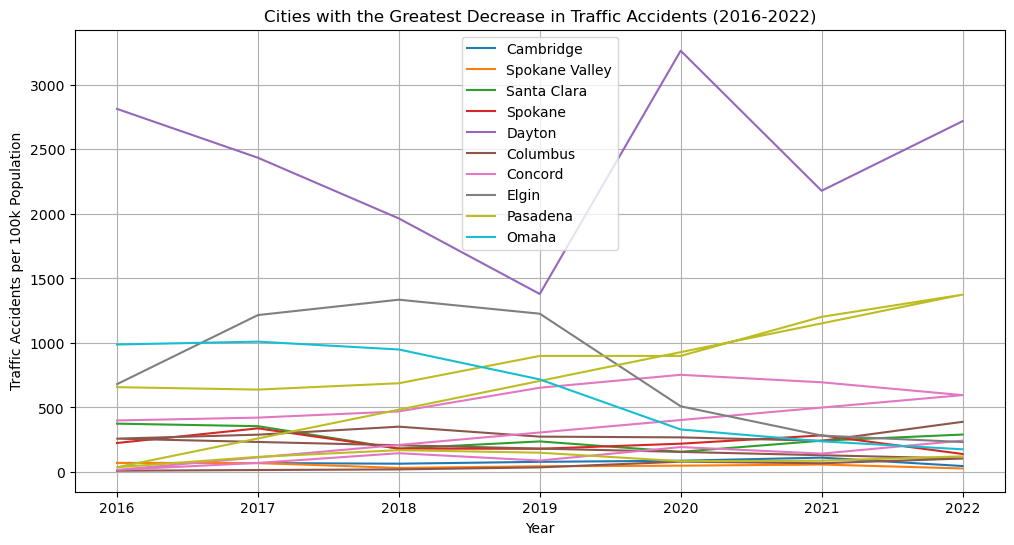

In [72]:
accidents_change['Change'] =accidents_change['accidents_per_pop_100K_2022'] - accidents_change['accidents_per_pop_100K_2016']
# Sort by the change in accidents (highest increase first)
accidents_change = accidents_change.sort_values(by='Change', ascending=False)

# Get the top 10 cities with the greatest increase and decrease
top_increase_cities = accidents_change.head(10)
top_decrease_cities = accidents_change.tail(10)

# line charts for cities with the greatest increase in traffic accidents
plt.figure(figsize=(12, 6))
for city in top_increase_cities['City']:
    major_cities_series= major_cities['City'] == city
    time_series= (major_cities["Start_Year"] >= FIRST_YEAR) & (major_cities["Start_Year"] <= LAST_YEAR)
    data = major_cities[major_cities_series & time_series]
    plt.plot(data['Start_Year'], data['accidents_per_pop_100K'], label=city)

plt.xlabel('Year')
plt.ylabel('Traffic Accidents per 100k Population')
plt.title('Cities with the Greatest Increase in Traffic Accidents (2016-2022)')
plt.legend()
plt.grid(True)
plt.savefig('greatest increase of traffic.png')
plt.show()

# Create line charts for cities with the greatest decrease in traffic accidents
plt.figure(figsize=(12, 6))
for city in top_decrease_cities['City']:
    major_cities_series= major_cities['City'] == city
    time_series= (major_cities["Start_Year"] >= FIRST_YEAR) & (major_cities["Start_Year"] <= LAST_YEAR)
    data = major_cities[major_cities_series & time_series]
    plt.plot(data['Start_Year'], data['accidents_per_pop_100K'], label=city)

plt.xlabel('Year')
plt.ylabel('Traffic Accidents per 100k Population')
plt.title('Cities with the Greatest Decrease in Traffic Accidents (2016-2022)')
plt.legend()
plt.grid(True)
plt.savefig('greatest decrease of traffic.png')
plt.show()

# Question: How does weather affect frequency of traffic accidents?

#### Author: Aspen Jack


In [53]:
census_traffic_df.dtypes

Start_Time            object
End_Time              object
Severity               int64
City                  object
State                 object
Weather_Condition     object
Temperature(F)       float64
Visibility(mi)       float64
Wind_Speed(mph)      float64
Precipitation(in)    float64
Sunrise_Sunset        object
Description           object
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Description           object
Start_Date            object
End_Date              object
Start_Year             int64
End_Year               int64
City1                 object
State_old             object
Population             int64
State #               object
Place #               object
City_State    

In [54]:
#Filter DataFrame for year 2022
census_2022 = census_traffic_df.loc[census_traffic_df["Start_Year"] == 2022]
census_2022

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
5684,2022-09-08 14:28:57,2022-09-08 15:18:00,3,Dayton,OH,Partly Cloudy,78.0,10.00,7.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5685,2022-09-08 06:57:05,2022-09-08 07:26:51,1,Dayton,OH,Fair,56.0,10.00,3.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5686,2022-09-07 16:01:45,2022-09-07 16:45:39,3,Dayton,OH,Partly Cloudy,78.0,10.00,10.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5687,2022-09-07 08:01:51,2022-09-07 09:01:47,3,Dayton,OH,Cloudy,63.0,5.00,3.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5688,2022-09-06 18:07:54,2022-09-06 18:56:00,3,Dayton,OH,Cloudy,75.0,10.00,13.0,0.0,...,2022-09-06,2022-09-06,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5544703,2022-07-24 18:47:08.000000000,2022-07-24 20:03:08.000000000,2,McGregor,TX,Fair,101.0,10.00,13.0,0.0,...,2022-07-24,2022-07-24,2022,2022,McGregor city,Texas,5345,48,45672,"McGregor city, Texas"
5544704,2022-07-12 16:17:00,2022-07-12 21:02:00,2,Burkesville,KY,Heavy Rain / Windy,73.0,1.00,22.0,0.0,...,2022-07-12,2022-07-12,2022,2022,Burkesville city,Kentucky,1470,21,11098,"Burkesville city, Kentucky"
5544705,2022-12-21 13:15:02.000000000,2022-12-21 16:36:00.000000000,2,Box Elder,SD,Blowing Snow / Windy,-11.0,0.12,30.0,0.0,...,2022-12-21,2022-12-21,2022,2022,Box Elder city,South Dakota,11527,46,06620,"Box Elder city, South Dakota"
5544706,2022-12-31 13:46:59.000000000,2022-12-31 15:47:31.000000000,2,Dovray,MN,NaN,NaN,NaN,NaN,NaN,...,2022-12-31,2022-12-31,2022,2022,Dovray city,Minnesota,48,27,16300,"Dovray city, Minnesota"


In [55]:
#Filter DataFrame further to cities with population over 100k
census_100k_2022 = census_2022.loc[census_2022["Population"] > 100000]
census_100k_2022

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
5684,2022-09-08 14:28:57,2022-09-08 15:18:00,3,Dayton,OH,Partly Cloudy,78.0,10.0,7.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5685,2022-09-08 06:57:05,2022-09-08 07:26:51,1,Dayton,OH,Fair,56.0,10.0,3.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5686,2022-09-07 16:01:45,2022-09-07 16:45:39,3,Dayton,OH,Partly Cloudy,78.0,10.0,10.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5687,2022-09-07 08:01:51,2022-09-07 09:01:47,3,Dayton,OH,Cloudy,63.0,5.0,3.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5688,2022-09-06 18:07:54,2022-09-06 18:56:00,3,Dayton,OH,Cloudy,75.0,10.0,13.0,0.0,...,2022-09-06,2022-09-06,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478722,2022-12-28 20:35:30.000000000,2022-12-29 00:02:25.000000000,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-29,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"
5478723,2022-12-28 20:40:44,2022-12-28 21:55:44,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-28,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"
5478724,2022-12-28 20:35:30,2022-12-29 00:02:25,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-29,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"
5478725,2022-12-28 20:35:30.000000,2022-12-28 22:48:30.000000,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-28,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"


In [68]:
#Set variables
temp_counts = census_100k_2022["Temperature(F)"].value_counts()
temp_counts

 79.0    19736
 77.0    18885
 73.0    18368
 81.0    17718
 80.0    17639
         ...  
-44.0        1
-22.0        1
-19.0        1
-24.0        1
-17.0        1
Name: Temperature(F), Length: 141, dtype: int64

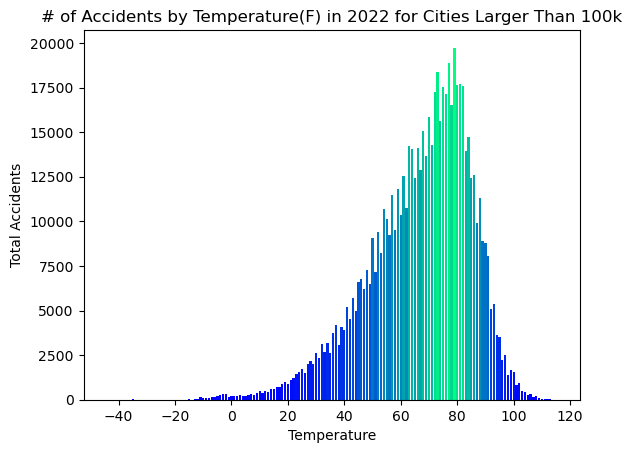

In [106]:
#Create bar graph with title, labels, & colorscale
x_axis = temp_counts.index.tolist()
y_axis = temp_counts.tolist()

my_cmap = plt.get_cmap("winter")
rescale = lambda y_axis: (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))
plt.bar(x_axis,y_axis, color=my_cmap(rescale(y_axis)))

plt.title("# of Accidents by Temperature(F) in 2022 for Cities Larger Than 100k")
plt.xlabel("Temperature")
plt.ylabel("Total Accidents")
#Save as PNG
plt.savefig("outputs/temperature_vs_accidents.png")
plt.show()

The most frequent temperature where traffic accidents occurred in the US in 2022 is 79°F. The top 5 temperatures where traffic accidents occurred in the US in 2022 range between 73°F and 80°F, showing that car accidents are most likely to occur on warm days rather than freezing or cold temperatures. This could be because more people are out driving in mild weather than when temperatures are in extreme highs or lows. 

In [71]:
#Set variables 
top_wx = census_100k_2022["Weather_Condition"].value_counts().head(10)
top_wx

Fair             341964
Mostly Cloudy    113833
Cloudy            83658
Partly Cloudy     73111
Light Rain        25810
Light Snow         6851
Fog                6573
Rain               5636
Fair / Windy       5037
Haze               5027
Name: Weather_Condition, dtype: int64

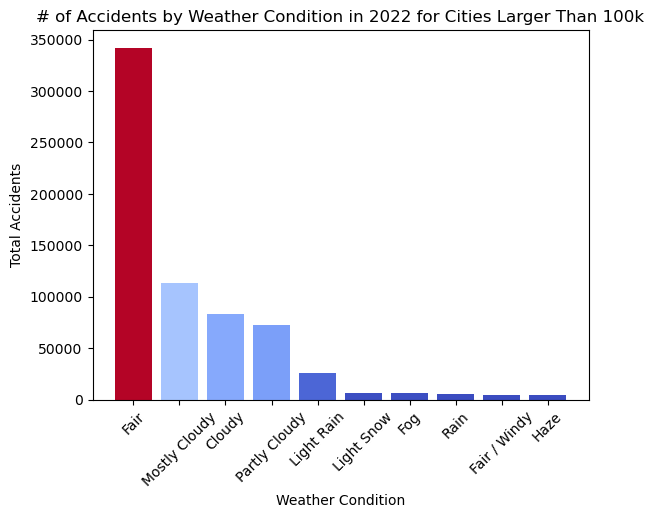

In [104]:
#Create bar graph with title, labels, & colorscale

x_axis=top_wx.index.tolist()
y_axis = top_wx.tolist()

my_cmap = plt.get_cmap("coolwarm")
rescale = lambda y_axis: (y_axis - np.min(y_axis)) / (np.max(y_axis) - np.min(y_axis))
plt.bar(x_axis,y_axis, color=my_cmap(rescale(y_axis)))
plt.xticks(rotation=45)
plt.title("# of Accidents by Weather Condition in 2022 for Cities Larger Than 100k")
plt.xlabel("Weather Condition")
plt.ylabel("Total Accidents")
#Save as PNG
plt.savefig("outputs/wx_condition_vs_accidents.png")
plt.show()

This data further supports the previous trend shown with temperature. The most commonly occurring weather condition associated with car accidents in the us in 2022 is "Fair", meaning fair weather at the time of the accident. This is most likely due to more people being on the road when the weather is fair than in inclement weather.

In [73]:
#What time of day were accidents most likely to happen? 
#Author: Velvet Robinson
day_v_night = organized_traffic_df.groupby(["Start_Year","Sunrise_Sunset"]).count().reset_index()

day_series = day_v_night["Sunrise_Sunset"] == "Day"
night_series = day_v_night["Sunrise_Sunset"] == "Night"

In [74]:
day_df = day_v_night.loc[day_series]
day_count= day_df[["Start_Year","State"]]
day_count_r = day_count.rename(columns={"State":"Day_Count"})

night_df = day_v_night.loc[night_series]
night_count= night_df[["Start_Year","State"]]
night_count_r = night_count.rename(columns={"State":"Night_Count"})

day_night_df = pd.merge(night_count_r,day_count_r,on="Start_Year")

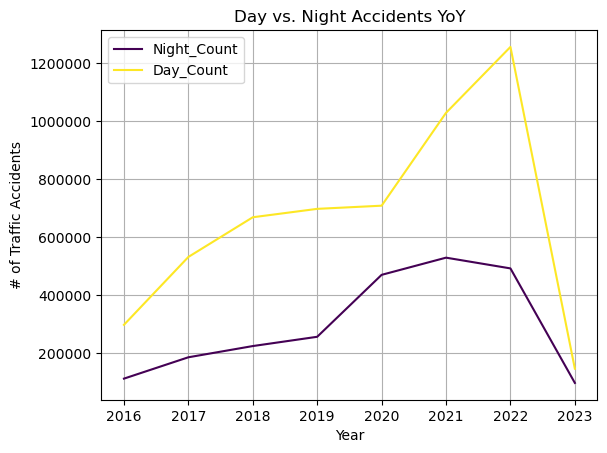

In [75]:
day_night_df.plot(x="Start_Year",kind="line",grid=True,colormap='viridis')
plt.ticklabel_format(style='plain')

plt.title("Day vs. Night Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/NigthtvDay.png")
plt.show()

In [76]:
#Adding total accidents to DF
total_accident = day_night_df[["Night_Count","Day_Count"]].sum(axis=1)
day_night_df["Total_Count"] = total_accident

In [77]:
#adding percentage of night v. day accidents
day_percent = (day_night_df["Day_Count"]/day_night_df["Total_Count"]) * 100
night_percent = (day_night_df["Night_Count"]/day_night_df["Total_Count"]) * 100

day_night_df["Night_Pct"] = night_percent.map("{:,.2f}%".format)
day_night_df["Day_Pct"] = day_percent.map("{:,.2f}%".format)


day_night_df

,Start_Year,Night_Count,Day_Count,Total_Count,Night_Pct,Day_Pct
0,2016,112742,298048,410790,27.45%,72.55%
1,2017,186263,531794,718057,25.94%,74.06%
2,2018,224905,668504,893409,25.17%,74.83%
3,2019,256833,697447,954280,26.91%,73.09%
4,2020,470174,708362,1178536,39.89%,60.11%
5,2021,529367,1028195,1557562,33.99%,66.01%
6,2022,492367,1255189,1747556,28.17%,71.83%
7,2023,97944,147014,244958,39.98%,60.02%


# What time of day do accidents happen for daytime accidents? 
Bar graph for when accidents happened by hour for city with max number of accidents in 2022

Author: Velvet Robinson

In [78]:
def time(raw):
    #time_string = raw[11:]
    time = dt.datetime.fromisoformat(raw).time()
    time_string = time.isoformat()
    return time_string

In [79]:
organized_traffic_df.loc[:, "Start_Timestamp"] = organized_traffic_df['Start_Time'].map(time)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/1431660003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  organized_traffic_df.loc[:, "Start_Timestamp"] = organized_traffic_df['Start_Time'].map(time)


In [80]:
tod= "Day"
tod_time_accidents = organized_traffic_df[organized_traffic_df["Sunrise_Sunset"]== tod]
tod_time_accidents_og = tod_time_accidents[["Start_Year","Start_Time","End_Time","Start_Timestamp","Sunrise_Sunset","State"]]
tod_time_accidents_og

,Start_Year,Start_Time,End_Time,Start_Timestamp,Sunrise_Sunset,State
4,2016,2016-02-08 07:39:07,2016-02-08 08:09:07,07:39:07,Day,OH
5,2016,2016-02-08 07:44:26,2016-02-08 08:14:26,07:44:26,Day,OH
6,2016,2016-02-08 07:59:35,2016-02-08 08:29:35,07:59:35,Day,OH
7,2016,2016-02-08 07:59:58,2016-02-08 08:29:58,07:59:58,Day,OH
8,2016,2016-02-08 08:00:40,2016-02-08 08:30:40,08:00:40,Day,OH
...,...,...,...,...,...,...
7728389,2019,2019-08-23 18:03:25,2019-08-23 18:32:01,18:03:25,Day,CA
7728390,2019,2019-08-23 19:11:30,2019-08-23 19:38:23,19:11:30,Day,CA
7728391,2019,2019-08-23 19:00:21,2019-08-23 19:28:49,19:00:21,Day,CA
7728392,2019,2019-08-23 19:00:21,2019-08-23 19:29:42,19:00:21,Day,CA


In [81]:
Year = 2022
single_yr_df = tod_time_accidents_og[tod_time_accidents_og["Start_Year"]==Year]

In [82]:
single_yr_df.loc[:,"Hour"] = pd.to_datetime(single_yr_df["Start_Timestamp"],format='%H:%M:%S').dt.hour

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/719576505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_yr_df.loc[:,"Hour"] = pd.to_datetime(single_yr_df["Start_Timestamp"],format='%H:%M:%S').dt.hour


In [83]:
# Establish the bins 
morning_bins = [3,12,18,21]
labels = ["Morning 4am-12pm","Afternoon 1pm-6pm","Evening 7pm-9pm"]

In [84]:
single_yr_df.loc[:,"Time of Day Ranges"] = pd.cut(single_yr_df["Hour"],morning_bins,labels=labels)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_17102/4203710015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_yr_df.loc[:,"Time of Day Ranges"] = pd.cut(single_yr_df["Hour"],morning_bins,labels=labels)


In [85]:
single_yr_gp = single_yr_df.groupby("Time of Day Ranges").count()
single_yr_og = single_yr_gp[["State"]]
single_yr_rn = single_yr_og.rename(columns={"State":"Count"})

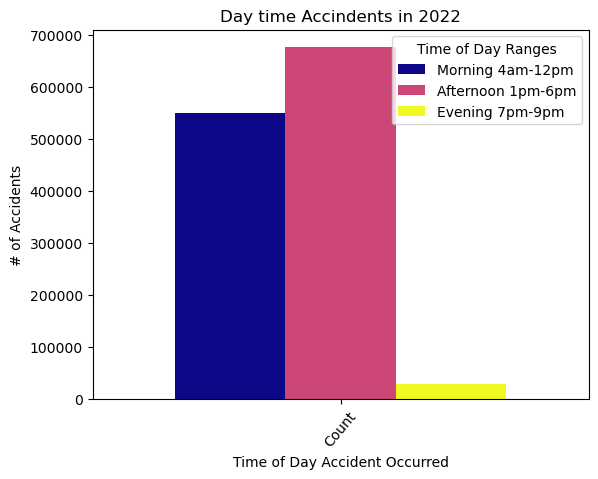

In [86]:
single_yr_rn.transpose().plot(kind="bar",width=1, xlabel="Time of Day Accident Occurred",
                              title=f"{tod} time Accindents in {Year}", ylabel="# of Accidents",
                              rot=50, colormap='plasma'
                              )

plt.savefig("outputs/2022DaytimeAccidents.png")
plt.show()

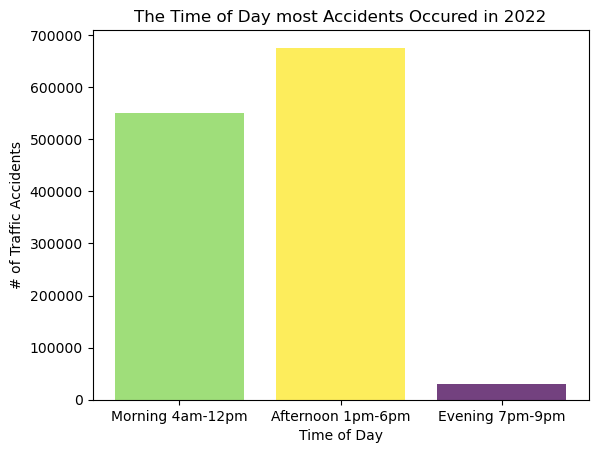

In [87]:
x = single_yr_rn.index.to_list()
y = single_yr_rn["Count"].to_list()

my_cmap = plt.get_cmap("viridis")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.bar(x, y, color=my_cmap(rescale(y)), alpha=0.75)

plt.title(f"The Time of Day most Accidents Occured in 2022")
plt.xlabel(f"Time of Day")
plt.ylabel(f"# of Traffic Accidents")

plt.savefig("outputs/2022DaytimeAccidentsv2.png")
plt.show()

# What were the most frequent types of accidents that happened? 
Author: Christina Zermeno

In [108]:
organized_traffic_df.columns

Index(['Start_Year', 'Start_Date', 'End_Year', 'End_Date', 'Start_Time',
       'End_Time', 'Severity', 'City', 'State', 'Weather_Condition',
       'Temperature(F)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Sunrise_Sunset', 'Description', 'Description',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Start_Timestamp'],
      dtype='object')

In [109]:
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Timestamp
0,2016,2016-02-08,2016,2016-02-08,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,05:46:00
1,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,06:07:59
2,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,...,False,False,False,False,False,False,False,True,False,06:49:27
3,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,07:23:34
4,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,True,False,07:39:07


Number of Accidents for Each Road Location Type

In [110]:
traffic_types_df = organized_traffic_df[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop']]
traffic_types_df.head()

,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


In [111]:
#Number of Accidents in each Type
traffic_types_df.sum()

Bump                  3514
Crossing            873763
Give_Way             36582
Junction            571342
No_Exit              19545
Railway              66979
Roundabout             249
Station             201901
Stop                214371
Traffic_Calming       7598
Traffic_Signal     1143772
Turning_Loop             0
dtype: int64

<Axes: >

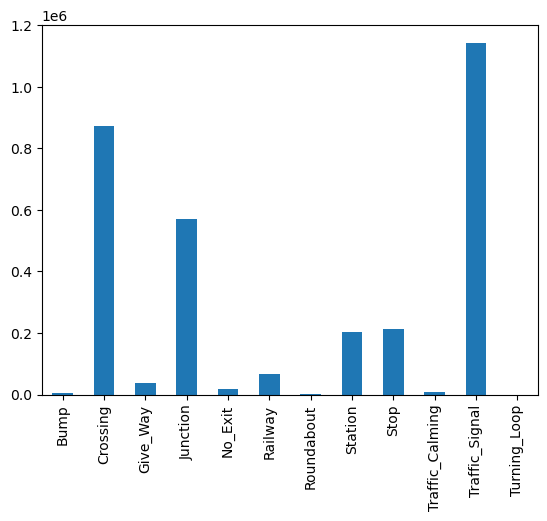

In [112]:
traffic_types_df.sum().plot(kind="bar")

In [113]:
#Miami has the most number of accidents
organized_traffic_df["City"].value_counts()

Miami                           186917
Houston                         169609
Los Angeles                     156491
Charlotte                       138652
Dallas                          130939
                                 ...  
Benkelman                            1
Old Appleton                         1
Wildrose                             1
Mc Nabb                              1
American Fork-Pleasant Grove         1
Name: City, Length: 13678, dtype: int64

In [114]:
organized_traffic_Miami_df = organized_traffic_df[organized_traffic_df["City"] == "Miami"] 
organized_traffic_Miami_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Timestamp
116057,2016,2016-11-30,2016,2016-11-30,2016-11-30 16:40:31,2016-11-30 17:10:19,2,Miami,FL,Mostly Cloudy,...,False,False,False,False,False,True,False,True,False,16:40:31
116060,2016,2016-11-30,2016,2016-11-30,2016-11-30 15:16:19,2016-11-30 17:01:03,2,Miami,FL,Scattered Clouds,...,False,False,False,False,False,False,False,True,False,15:16:19
116061,2016,2016-11-30,2016,2016-11-30,2016-11-30 16:55:31,2016-11-30 17:25:11,2,Miami,FL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,16:55:31
116062,2016,2016-11-30,2016,2016-11-30,2016-11-30 16:57:23,2016-11-30 17:27:10,3,Miami,FL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,16:57:23
116064,2016,2016-11-30,2016,2016-11-30,2016-11-30 17:15:52,2016-11-30 17:45:36,2,Miami,FL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,17:15:52


In [115]:
traffic_types_miami_df = organized_traffic_Miami_df[['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop']]
traffic_types_miami_df.sum()

Bump                 216
Crossing           50600
Give_Way             509
Junction            9108
No_Exit             2111
Railway             1417
Roundabout            34
Station            23415
Stop                8540
Traffic_Calming      913
Traffic_Signal     27442
Turning_Loop           0
dtype: int64

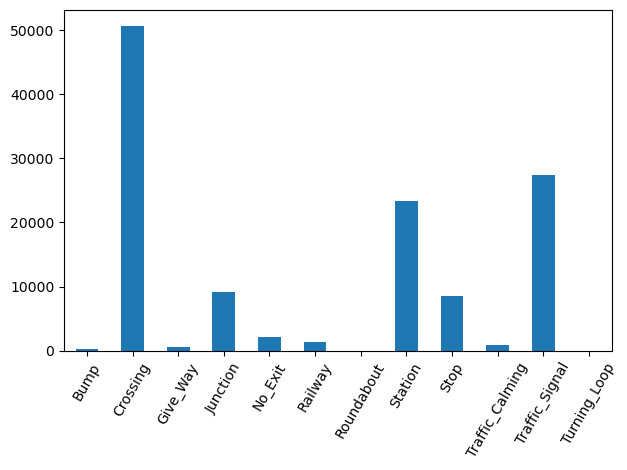

In [116]:
traffic_types_miami_df.sum().plot(kind = "bar", rot = 60)
plt.tight_layout()
plt.savefig("outputs/MiamiTrafficTypes2022.png")
plt.show()

In [98]:
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Timestamp
0,2016,2016-02-08,2016,2016-02-08,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,05:46:00
1,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,06:07:59
2,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,...,False,False,False,False,False,False,False,True,False,06:49:27
3,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,07:23:34
4,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,True,False,07:39:07


In [99]:
organized_traffic_df.Start_Year.value_counts()

2022    1762452
2021    1563753
2020    1178913
2019     954303
2018     893426
2017     718093
2016     410821
2023     246633
Name: Start_Year, dtype: int64

In [101]:
Miami_Traffic_df = organized_traffic_Miami_df.groupby(["Start_Year"], as_index=False).count() 
Miami_Traffic_df

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Timestamp
0,2016,5147,5147,5147,5147,5147,5147,5147,5147,5127,...,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
1,2017,9235,9235,9235,9235,9235,9235,9235,9235,9162,...,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235
2,2018,8659,8659,8659,8659,8659,8659,8659,8659,8604,...,8659,8659,8659,8659,8659,8659,8659,8659,8659,8659
3,2019,8146,8146,8146,8146,8146,8146,8146,8146,8122,...,8146,8146,8146,8146,8146,8146,8146,8146,8146,8146
4,2020,27103,27103,27103,27103,27103,27103,27103,27103,26764,...,27103,27103,27103,27103,27103,27103,27103,27103,27103,27103
5,2021,58845,58845,58845,58845,58845,58845,58845,58845,58675,...,58845,58845,58845,58845,58845,58845,58845,58845,58845,58845
6,2022,64544,64544,64544,64544,64544,64544,64544,64544,63692,...,64544,64544,64544,64544,64544,64544,64544,64544,64544,64544
7,2023,5238,5238,5238,5238,5238,5238,5238,5238,5186,...,5238,5238,5238,5238,5238,5238,5238,5238,5238,5238


In [102]:
Miami_Traffic_16_22_df = Miami_Traffic_df[Miami_Traffic_df["Start_Year"]< 2023]
Miami_Traffic_16_22_df

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Start_Timestamp
0,2016,5147,5147,5147,5147,5147,5147,5147,5147,5127,...,5147,5147,5147,5147,5147,5147,5147,5147,5147,5147
1,2017,9235,9235,9235,9235,9235,9235,9235,9235,9162,...,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235
2,2018,8659,8659,8659,8659,8659,8659,8659,8659,8604,...,8659,8659,8659,8659,8659,8659,8659,8659,8659,8659
3,2019,8146,8146,8146,8146,8146,8146,8146,8146,8122,...,8146,8146,8146,8146,8146,8146,8146,8146,8146,8146
4,2020,27103,27103,27103,27103,27103,27103,27103,27103,26764,...,27103,27103,27103,27103,27103,27103,27103,27103,27103,27103
5,2021,58845,58845,58845,58845,58845,58845,58845,58845,58675,...,58845,58845,58845,58845,58845,58845,58845,58845,58845,58845
6,2022,64544,64544,64544,64544,64544,64544,64544,64544,63692,...,64544,64544,64544,64544,64544,64544,64544,64544,64544,64544


In [103]:
traffic_types_df = organized_traffic_Miami_df[['Start_Year','Crossing', 'Junction',
                                          'Station', 'Traffic_Signal']]
traffic_groupby = traffic_types_df.groupby("Start_Year", as_index = False).sum()
traffic_groupby

,Start_Year,Crossing,Junction,Station,Traffic_Signal
0,2016,1062,553,198,1419
1,2017,1713,1103,424,2257
2,2018,1648,904,334,2309
3,2019,1479,842,362,1815
4,2020,7598,1907,3179,4518
5,2021,17852,1471,9194,7222
6,2022,17719,2059,9170,6838
7,2023,1529,269,554,1064


In [104]:
Miami_Traffic_16_22_df = traffic_groupby[traffic_groupby["Start_Year"]< 2023]
Miami_Traffic_16_22_df

,Start_Year,Crossing,Junction,Station,Traffic_Signal
0,2016,1062,553,198,1419
1,2017,1713,1103,424,2257
2,2018,1648,904,334,2309
3,2019,1479,842,362,1815
4,2020,7598,1907,3179,4518
5,2021,17852,1471,9194,7222
6,2022,17719,2059,9170,6838


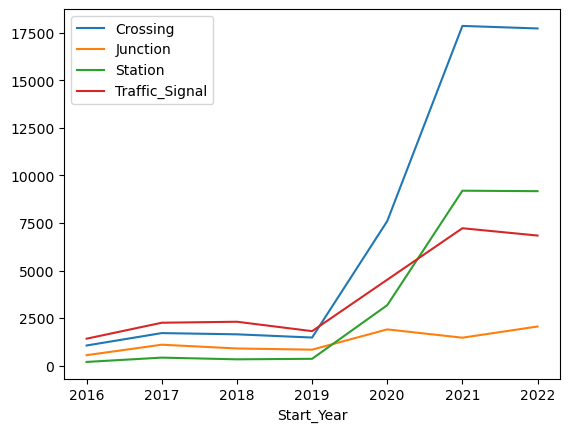

In [105]:
Miami_Traffic_16_22_df.plot(x="Start_Year", kind = "line")

plt.savefig("outputs/20162022MiamitopAccidentLocations.png")
plt.show()